# Clear Sky Composite of Goes-16 Images

## Step 1: Setting work environment

Importing libraries

In [3]:
import calendar, datetime, os, random
import cartopy.crs as ccrs
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as sch
import xarray as xr

from matplotlib import cm
from PIL import Image
from sklearn.cluster import AgglomerativeClustering
from sewar.full_ref import mse, vifp

Input/output path and locations/period of interest

In [ ]:
# Input: path where the files with .nc extension are located
path_input = " "

# Output 1: path where the cropped .nc files will be saved
path_output_1 = " "

# Output 2: path where the composite files with .nc extensions will be saved
path_output_2 =  " "

# Output 3: path where the clear sky images will be saved
path_output_3 = " "

# Year and months of interest
# IMPORTANT: months must be in the string format, in the 01-12 range
year = 2019
months = ['01', '04', '07', '10']

# Locations: list with names, latitudes and longitudes of the areas of interest
locations = [['brb', -15.60083, -47.71306],
             ['cpa', -22.6896, -45.0062],
             ['ptr', -9.0689, -40.3197],
             ['sms', -29.4428, -53.8231]]

## Part 2: cropping NetCDF files

In [ ]:
# Setting file paths where the .nc files are located
directory = os.fsencode(path_input)
os.chdir(path_input)

# Looping through the selected months
for month in months:
    
    # Setting start and end date in julian day format
    day_start = calendar.monthrange(year, int(month))[0]
    day_end = calendar.monthrange(year, int(month))[1]

    julian_start = datetime.datetime.strptime(month + '.' + str(day_start), '%m.%d').timetuple().tm_yday
    julian_end = datetime.datetime.strptime(month + '.' + str(day_end), '%m.%d').timetuple().tm_yday

    # Creating list with range of julian days which will be further used to locate the respective files
    days = []

    for day in range(julian_start, julian_end + 1):
        if day < 10:
            days.append('00' + str(day))
        elif day < 100:
            days.append('0' + str(day))
        else:
            days.append(str(day))
    
    # Looping through locations
    for location in locations:
        
        # Looping through the files 
        for file in os.listdir(directory):
            
            file = file.decode('utf-8')
            
            # Matching the file with the desired month
            if file[-13:-10] in days:
                ds = xr.open_dataset(file)

                # Extracting the date from the file
                date = str(ds.attrs['date_created'])

                # Selecting the variables
                lon = ds['lon'].values
                lat = ds['lat'].values

                # Setting the value of k, this is the size of our box around the location
                k = 2.0

                # Setting the latitude and latitude
                lat_station = location[1]
                lon_station = location[2]
                lat_list = list(lat)
                lon_list = list(lon)

                # Finding the closest point in the dataset that matches our location latitude and longitude
                lat_start = lat_list.index(lat_list[min(range(len(lat_list)), key = lambda i: abs(lat_list[i]-(lat_station - k)))])
                lat_end = lat_list.index(lat_list[min(range(len(lat_list)), key = lambda i: abs(lat_list[i]-(lat_station + k)))])
                lon_start = lon_list.index(lon_list[min(range(len(lon_list)), key = lambda i: abs(lon_list[i]-(lon_station - k)))])
                lon_end = lon_list.index(lon_list[min(range(len(lon_list)), key = lambda i: abs(lon_list[i]-(lon_station + k)))])

                # Setting the new .nc file with our specified dimensions
                data = ds['CMI'][lat_start:lat_end, lon_start:lon_end]

                # Naming our file with the date and time
                file = location[0] + '_' + date[0:4] + '_' + date[5:7] + '_' + date[8:10] + '_' + date[11:13] + date[14:16]

                # Saving the cropped NetCDF file
                data.to_netcdf(path=(path_output_1 + f'\{file}.nc'))
                ds.close()

## Part 3: Plotting cropped NetCDF

In [ ]:
# Changing directory
directory = os.fsencode(path_output_2)
os.chdir(path_output_2)

# Looping through locations
for location in locations:
    
    # Looping through files in folder
    for file in os.listdir(directory):
        
        # Opening dataset
        file = file.decode('utf-8')
        ds = xr.open_dataset(file)

        # Plotting the image
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        mapa = ds['CMI'].plot(ax=ax,transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False, cmap='gray', vmax=0.8, vmin=0)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(mapa, cax=cax).remove()
        gl = ax.grid(True)

        # Saving image
        file = file[0:-3] + '.png'
        plt.savefig(path_output_3 + f'\{file}')
        plt.close()
        ds.close()

## Part 4: Creating clear/overcast sky compositions

In [ ]:
# Setting locations
locations = ['brb', 'cpa', 'ptr', 'sms']

# Setting months
months = ['01', '04', '07', '10']

# Available times
times = ['1300', '1310', '1320', '1330', '1340', '1350',
        '1400', '1410', '1420', '1430', '1440', '1450',
        '1500', '1510', '1520', '1530', '1540', '1550',
        '1600', '1610', '1620', '1630', '1640', '1650',
        '1700', '1710', '1720', '1730', '1740', '1750',
        '1800', '1810', '1820', '1830', '1840', '1850',
        '1900', '1910', '1920', '1930', '1940', '1950',
        '2000', '2010', '2020', '2030', '2040', '2050',]

# Creating lists to store values
time_arrays = []
time_keys = []

path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\recortadas'
directory = os.fsencode(path)
os.chdir(path)

location = 'cpa'
month = '03'

for time in times:
    
    arrays = []
    
    for file in os.listdir(directory):
        
        file = file.decode('utf-8')
        
        if file[0:3] == location and file[9:11] == month and file[15:19] == time:
            ds = xr.open_dataset(file)
            arrays.append(ds.CMI.values)
            ds.close()
            
    if len(arrays) >= 25:
        time_keys.append(time)
        time_arrays.append(arrays)
        
data_dict = dict(zip(time_keys, time_arrays))

In [ ]:
path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\recortadas'
directory = os.fsencode(path)
os.chdir(path)

ds_ref = xr.open_dataset('brb_2019_01_01_0950.nc')


for key, value in data_dict.items():
    
    # Creating folder for netcdf files
    new_dir = key
    parent_dir = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}'
    path_new = os.path.join(parent_dir, new_dir)
    os.mkdir(path_new)
    
    # Creating folder for png files
    parent_dir2 = rf'C:\Users\rodri\Desktop\composicoes\{location}\imagens\{month}'
    path_new2 = os.path.join(parent_dir2, new_dir)
    os.mkdir(path_new2)
    
    for i in range(0, len(value)):
        ds = xr.Dataset({"CMI": (("lat", "lon"), np.sort(value,0)[i])}, coords={"lat": ds_ref.lat.values,"lon": ds_ref.lon.values})
        file_name = 'comp' + str(i) + '.nc'
        ds.to_netcdf(path=(rf'{path_new}\{file_name}'))
        ds = xr.open_dataset(rf'{path_new}\{file_name}')

        # Plotting the image
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        mapa = ds['CMI'].plot(ax=ax,transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False, cmap='gray', vmax=0.8, vmin=0)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(mapa, cax=cax).remove()
        gl = ax.grid(True)

        # Saving image
        file_name = 'comp' + str(i) + '.png'
        plt.savefig(rf'{path_new2}\{file_name}')
        plt.close()
        ds.close()

ds_ref.close()

del time_arrays
del time_keys
del arrays
del data_dict
del ds_ref
del ds
del mapa
del cax

## Part 6: Hierarchical Clustering (HC) and Cloud Cover Index (CCI)

In order to calculate the CCI we must first tell apart what objects are present in an image, cloud or surface.
To achieve this, we can make use of the Hierarchical clustering library.

In [10]:
# Setting location and month
location = 'sms'
month = '10'

# Setting sample value, this is how many random points will be extracted from each of the 30 compositions previously generated
sample = 200

# Setting NetCDf path to be used for clustering, in this case the file closer to noon, due to best solar geometry
netcdf_path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1510'

# Setting HC, we want 3 groups, clear sky, overcast and all the rest, which we will call partial overcast
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')

# This is a reference file, which will be used to compare our clustering
reference_netcdf_path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Com nuvens\{location}\{month}\netcdf'

# Finding the file closer to noon
for file in os.listdir(reference_netcdf_path):
    if int(file[11:15]) > 1508 and int(file[11:15]) < 1515:
        reference_file = file
        
reference_netcdf_path = reference_netcdf_path + '\\' + reference_file

# Creating lists where values will be stored
mses = []
vifps = []
categories = []

# We run the HC code 20 random times, but keep only the best results
for i in range(0,20):
    
    random.seed(i)
    ds_samples = []
    print(f'Initiating random seed {i}...')
    
    for file in os.listdir(netcdf_path):
        ds = xr.open_dataset(netcdf_path + '\\' + file)
        ds_samples.append(random.sample(ds.CMI.values.flatten().tolist(), sample))
        ds.close
        
    train_values = [item for elem in ds_samples for item in elem]
    X = np.reshape(train_values, (len(train_values),1))
    y_hc = hc.fit_predict(X)
    
    cats = []

    for j in range(0,3):

        cats.append(X[y_hc == j, 0].min())
        cats.append(X[y_hc == j, 0].max())

    cats.sort()
    categories.append(cats)
    
    ds_cluster = xr.open_dataset(reference_netcdf_path)
    ds_cluster_cmi = ds_cluster.CMI.values
    ds_real_cmi = ds_cluster_cmi.copy()

    ds_cluster_cmi = np.where(ds_cluster_cmi < cats[1], 0, ds_cluster_cmi)
    ds_cluster_cmi = np.where(((ds_cluster_cmi <= cats[3]) & (ds_cluster_cmi > cats[1])), 0.5, ds_cluster_cmi)
    ds_cluster_cmi = np.where(ds_cluster_cmi > cats[3], 1, ds_cluster_cmi)

    mses.append(mse(ds_cluster_cmi, ds_real_cmi))
    vifps.append(vifp(ds_cluster_cmi, ds_real_cmi))
    ds_cluster.close()
    del ds_cluster_cmi, ds_real_cmi
    
# Displaying best values
print(f'\nRandom seed with best VIFP value: {vifps.index(max(vifps))}')
print(f'Best VIFP value: {vifps[vifps.index(max(vifps))]}\n')
print(f'Random seed with best MSE value: {mses.index(min(mses))}')
print(f'Best MSE value: {mses[mses.index(min(mses))]}')

# Setting cluster values based on similarity index MSE and VIFP
# If the indices are from the same seed, said seed is the chosen one
if vifps.index(max(vifps)) == mses.index(min(mses)):
    
    best_seed = vifps.index(max(vifps))
    best_cats = categories[best_seed]
    
    print(f'\nThe best categories for clustering are:\n{best_cats}')

# If the MSE and VIFP best values belong to different seeds, pick seed solely on MSE
else:
    
    print('Best VIFP and MSE values do not match, choosing based on MSE only instead...')
    best_seed = mses.index(min(mses))
    best_cats = categories[best_seed]
    print(f'\nThe best categories for clustering are:\n{best_cats}')

Initiating random seed 0...
Initiating random seed 1...
Initiating random seed 2...
Initiating random seed 3...
Initiating random seed 4...
Initiating random seed 5...
Initiating random seed 6...
Initiating random seed 7...
Initiating random seed 8...
Initiating random seed 9...
Initiating random seed 10...
Initiating random seed 11...
Initiating random seed 12...
Initiating random seed 13...
Initiating random seed 14...
Initiating random seed 15...
Initiating random seed 16...
Initiating random seed 17...
Initiating random seed 18...
Initiating random seed 19...

Random seed with best VIFP value: 6
Best VIFP value: 0.41668597861951684

Random seed with best MSE value: 10
Best MSE value: 0.01168562654960681
Best VIFP and MSE values do not match, choosing based on MSE only instead...

The best categories for clustering are:
[0.039999961853027344, 0.296825110912323, 0.29841241240501404, 0.7174596190452576, 0.7177770733833313, 1.0752370357513428]


In [ ]:
# Plotting HC results
colors = ['blue', 'red', 'green']
labels = ['C1', 'C2', 'C3']

for i in range(0, clusters):
    plt.scatter(X[y_hc == i,0], X[y_hc == i,0], c = colors[i], label = labels[i])
plt.legend()
plt.show()

## Part 7: Saving CCI images

After obtaining the HC values, we can now calculate the CCI, the final result is an image where only clouds are present, removing anything related to the surface

In [15]:
# Setting clear and overcast parameters
clear_index = best_cats[1]
cloud_index = best_cats[4]

# Path where files will be saved
save_cluster_path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Cluster\{location}\{month}'
ds_path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Com nuvens\{location}\{month}\netcdf'

for file in os.listdir(ds_path):
    ds_2 = xr.open_dataset(ds_path + '\\' + file)
    file_name = file[0:-3] + '.png'
    ds_cmi = ds_2.CMI.values

    # Calculating CCI
    c_eff = (ds_cmi - clear_index)/(cloud_index - clear_index)

    # Replacing values 
    c_eff = np.where(c_eff < 0, 0, c_eff)
    c_eff = np.where(c_eff > 1, 1, c_eff)
    ds_2.close()

    # Rotating the array so it matches our geographical location, converting the file to 8-bit grayscale image
    im = Image.fromarray(np.uint8(cm.gist_earth(np.rot90(np.flip(c_eff.T), k=3))*255)).convert('LA')
    im.save(save_cluster_path + '\\' + file_name)

## Showing final result example

The final result consists of an image such as below, ready to be used in the optical flow algorithm

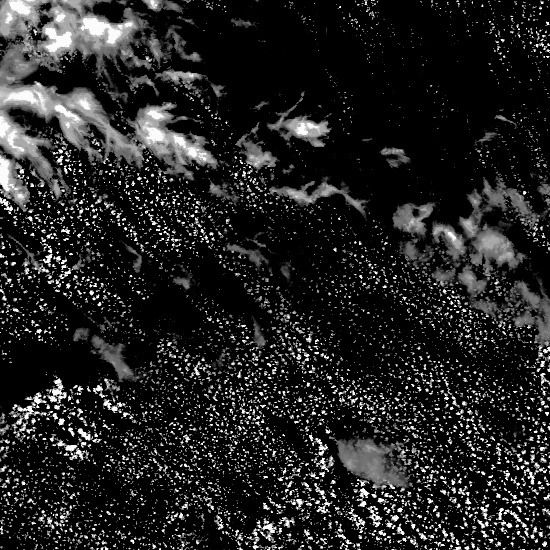

In [4]:
cluster_path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Cluster\ptr\01\2019_01_15_1626.png'
Image.open(cluster_path) 